In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

DIR = "/content/drive/MyDrive/Competitions/Signate/MUFG2023"
INPUT_DIR = os.path.join(DIR,"input")
OUTPUT_DIR = os.path.join(DIR,"output")
OOF_DIR = os.path.join(OUTPUT_DIR, 'oof')
SUB_NUM_DIR = os.path.join(OUTPUT_DIR, 'sub_num')

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import mean_squared_error,  mean_absolute_percentage_error
from sklearn.metrics import f1_score, accuracy_score

In [4]:
def get_f1_score(labels, outputs):
    y_pred = outputs
    y_true = labels
    best_score = 0
    best_thresh = 0.5
    for thresh in np.arange(0.1, 0.80, 0.01):
        thresh = np.round(thresh, 2)
        score = f1_score(y_true, (y_pred>thresh).astype(int))
        #print("Accuracy score at threshold {0} is {1}".format(thresh, score))
        if score > best_score:
          best_score = score
          best_thresh = thresh
    return f1_score(y_true, (y_pred>best_thresh).astype(int))

In [5]:
class CFG1:
  ver=85
  model="catboost"
  seed=42

class CFG2:
  ver=83
  model="catboost"
  seed=42

In [6]:
oof_df1 = pd.read_csv(os.path.join(OOF_DIR, f'oof_{CFG1.model}_ver{CFG1.ver}.csv'))
oof_df1.rename(columns={"pred":"pred1"},inplace=True)
oof_df2 = pd.read_csv(os.path.join(OOF_DIR, f'oof_{CFG2.model}_ver{CFG2.ver}.csv'))
oof_df2.rename(columns={"pred":"pred2"},inplace=True)

In [7]:
oof_df = oof_df1.merge(oof_df2[["index_x","pred2"]], how="left", on="index_x")

oof_df["model1"] = oof_df["pred1"].values
oof_df["model2"] = oof_df["pred2"].values

In [8]:
preds_df = oof_df[["is_fraud?","model1","model2"]].copy()
display(preds_df.corr())
print(preds_df.shape)
preds_df.dropna(axis=0,inplace=True)
print(preds_df.shape)
y_true = preds_df["is_fraud?"].values
preds_df.drop("is_fraud?",axis=1,inplace=True)

,is_fraud?,model1,model2
is_fraud?,1.000000,0.663978,0.705336
model1,0.663978,1.000000,0.931021
model2,0.705336,0.931021,1.000000


(471283, 3)
(471283, 3)


In [9]:
for i in range(2):
  score = get_f1_score(y_true, preds_df[f"model{i+1}"])
  print(f"model{i} : {score}")

model0 : 0.6693783285362196
model1 : 0.6682353749441792


In [10]:
oof_pred = preds_df["model1"]*.6 + preds_df["model2"]*.4

In [11]:
best_score = 0
best_thresh = 0.5
for thresh in np.arange(0.15, 0.801, 0.01):
    thresh = np.round(thresh, 2)
    score = f1_score(y_true, (oof_pred>thresh).astype(int))
    print("F1 score at threshold {0} is {1}".format(thresh, score))
    if score > best_score:
      best_score = score
      best_thresh = thresh
print()
print("best F1 score at threshold {0} is {1}".format(best_thresh, f1_score(y_true, (oof_pred>best_thresh).astype(int))))

F1 score at threshold 0.15 is 0.4102612413493243
F1 score at threshold 0.16 is 0.44041384799044964
F1 score at threshold 0.17 is 0.46968250386237786
F1 score at threshold 0.18 is 0.4970619708262151
F1 score at threshold 0.19 is 0.5223828058212393
F1 score at threshold 0.2 is 0.5447417468240536
F1 score at threshold 0.21 is 0.5654243743199129
F1 score at threshold 0.22 is 0.583355167567825
F1 score at threshold 0.23 is 0.5986769157935391
F1 score at threshold 0.24 is 0.6120928058581426
F1 score at threshold 0.25 is 0.6235124850408099
F1 score at threshold 0.26 is 0.6336886520097712
F1 score at threshold 0.27 is 0.6414340355083633
F1 score at threshold 0.28 is 0.6482516459400146
F1 score at threshold 0.29 is 0.6529463711065542
F1 score at threshold 0.3 is 0.6567560960704028
F1 score at threshold 0.31 is 0.659557907845579
F1 score at threshold 0.32 is 0.6630135250704761
F1 score at threshold 0.33 is 0.6647880066343537
F1 score at threshold 0.34 is 0.6668519487313628
F1 score at threshold 

In [12]:
class CFG:
  ver=90
  model="blending"

In [13]:
test_pred1 = pd.read_csv(os.path.join(SUB_NUM_DIR, f'submit_num_{CFG1.model}_ver{CFG1.ver}.csv'))
test_pred2 = pd.read_csv(os.path.join(SUB_NUM_DIR, f'submit_num_{CFG2.model}_ver{CFG2.ver}.csv'))

0    432741
1     25217
Name: 1, dtype: int64


,0,1
0,471283,0
1,471284,0
2,471285,0
3,471286,1
4,471287,0


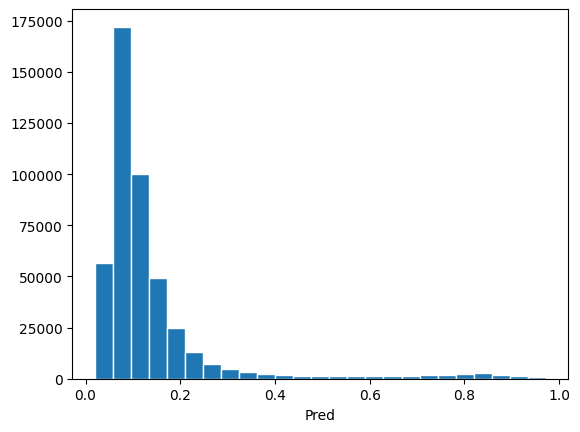

,0,1
0,471283,0
1,471284,0
2,471285,0
3,471286,1
4,471287,0
...,...,...
457953,929236,0
457954,929237,0
457955,929238,0
457956,929239,0


0         0.113806
1         0.219083
2         0.123660
3         0.565112
4         0.080653
            ...   
457953    0.092492
457954    0.079099
457955    0.070394
457956    0.188606
457957    0.078761
Name: pred, Length: 457958, dtype: float64

In [14]:
submit = pd.read_csv(os.path.join(INPUT_DIR,"sample_submit.csv"), header=None)
pred = test_pred1["pred"]*.6 + test_pred2["pred"]*.4
submit[1] = (pred>best_thresh).astype(int)

submit.to_csv(os.path.join(OUTPUT_DIR, f'submit_{CFG.model}_ver{CFG.ver}.csv'), index=False, header=None)
print(submit[1].value_counts())
display(submit.head())

plt.hist(pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

display(submit)
display(pred)